<a href="https://colab.research.google.com/github/yasinsoylu1997/64-64-UnderSampler/blob/main/hybr%C4%B1t_models__64*64128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report,confusion_matrix
import keras
import keras.utils
from keras import utils as np_utils
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#!pip install visualkeras
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import time
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
!pip install visualkeras


In [23]:
labels = ['Lung_Opacity','COVID','Normal','Viral Pneumonia']

In [24]:
X = []
y = []
image_size = 64
for i in labels:
    folderPath = os.path.join('/content/drive/MyDrive/tezz3/COVID-19_Radiography_Dataset_masked',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X.append(img)
        y.append(i)

        
X = np.array(X)
y = np.array(y)

100%|██████████| 1345/1345 [00:04<00:00, 292.04it/s]


In [25]:
from imblearn.under_sampling import RandomUnderSampler 
reshaped_X = X.reshape(X.shape[0],-1)

#oversampling
oversample = RandomUnderSampler()
oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

# reshaping X back to the first dims
new_X = oversampled_X.reshape(-1,64,64,3)
oversampled_y


array(['COVID', 'COVID', 'COVID', ..., 'Viral Pneumonia',
       'Viral Pneumonia', 'Viral Pneumonia'], dtype='<U15')

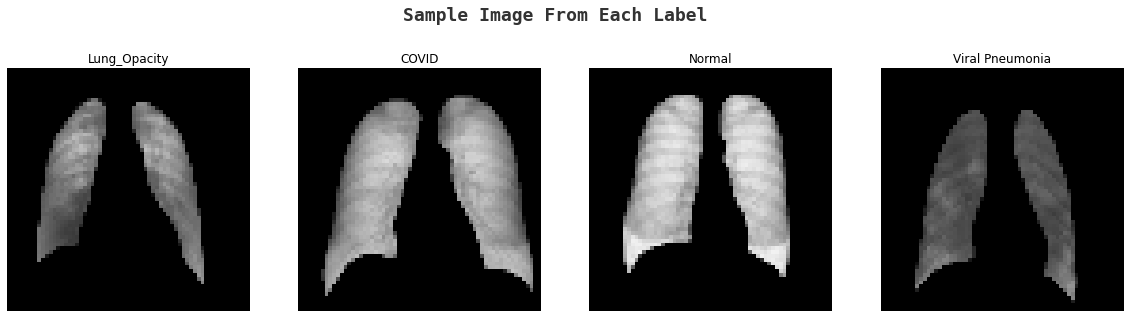

In [26]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y[j]==i:
            ax[k].imshow(X[j])
            ax[k].set_title(y[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [27]:
train_images, test_images,train_labels, test_labels = train_test_split(new_X , oversampled_y , test_size=0.25, random_state=42,shuffle=True)

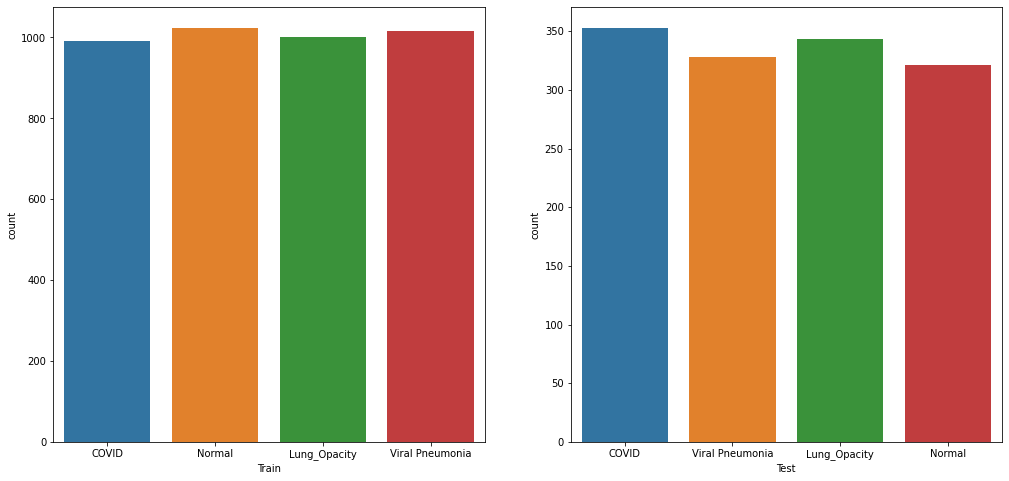

In [28]:
plt.figure(figsize = (17,8));
lis = ['Train', 'Test']
for i,j in enumerate([train_labels, test_labels]):
    plt.subplot(1,2, i+1);
    sns.countplot(x = j);
    plt.xlabel(lis[i])

In [29]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [30]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [31]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [32]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [33]:
y_test_one_hot

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [41]:
activation = 'relu'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(128, 3, activation = activation, padding = 'same', input_shape = (64, 64, 3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform',strides=(1, 1)))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D(pool_size=(3, 3)))

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform',strides=(1, 1)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform',strides=(1, 1)))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())


feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D(pool_size=(2, 2)))

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D(pool_size=(2, 2)))

feature_extractor.add(Flatten())

In [42]:
#Add layers for deep learning prediction
x = feature_extractor.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(4, activation = 'softmax')(x)

In [43]:
# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='adam',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12_input (InputLayer  [(None, 64, 64, 3)]      0         
 )                                                               
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 128)       3584      
                                                                 
 batch_normalization_12 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 32)        36896     
                                                                 
 batch_normalization_13 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                           

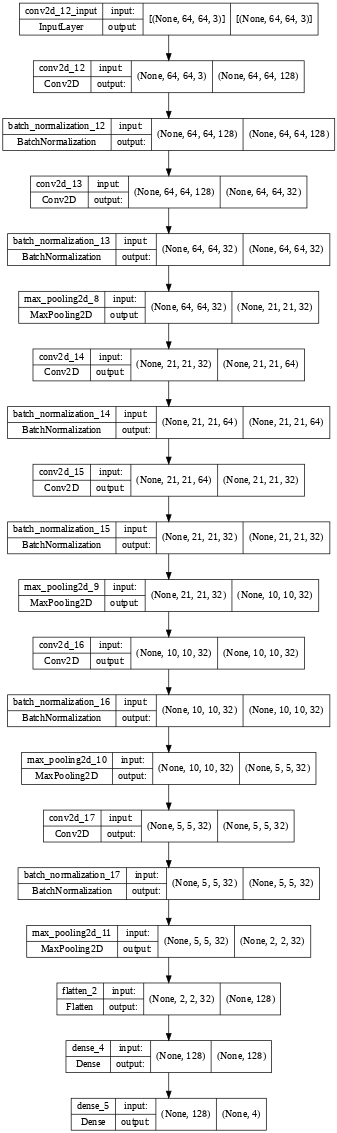

In [44]:
from keras.utils.vis_utils import plot_model

plot_model(cnn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=50)

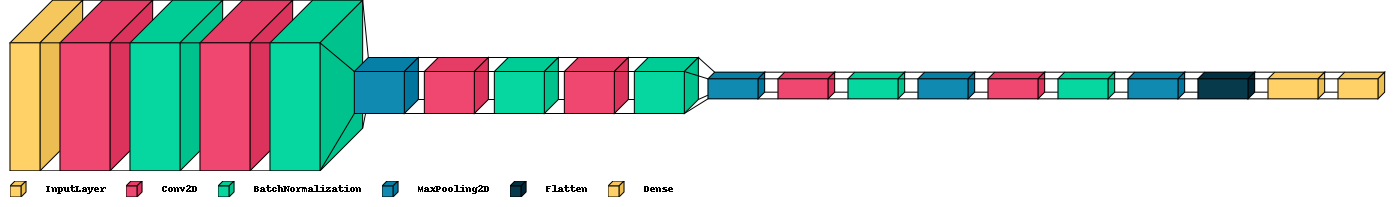

<Figure size 144x144 with 0 Axes>

In [45]:
import visualkeras
from PIL import ImageFont
plt.figure(figsize=(2, 2))
visualkeras.layered_view(cnn_model, legend=True,spacing=20,scale_xy = 2 , scale_z = 10, max_z = 50) 

In [46]:
checkpoint = ModelCheckpoint("cnn.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 2, min_delta = 0.0001,mode='auto',verbose=1)
early_stop=tf.keras.callbacks.EarlyStopping( monitor="val_accuracy",patience=5,verbose=1,mode="auto",)

In [47]:
#Train the CNN model
history = cnn_model.fit(x_train, y_train_one_hot, epochs=50, validation_data = (x_test, y_test_one_hot),batch_size=8,callbacks=[checkpoint,reduce_lr,early_stop])

Epoch 1/50
505/505 [==============================] - ETA: 0s - loss: 0.8989 - accuracy: 0.6126
Epoch 1: val_accuracy improved from -inf to 0.53457, saving model to cnn.h5
505/505 [==============================] - 14s 8ms/step - loss: 0.8989 - accuracy: 0.6126 - val_loss: 1.0341 - val_accuracy: 0.5346 - lr: 0.0010
Epoch 2/50
502/505 [============================>.] - ETA: 0s - loss: 0.6853 - accuracy: 0.7087
Epoch 2: val_accuracy improved from 0.53457 to 0.73606, saving model to cnn.h5
505/505 [==============================] - 3s 7ms/step - loss: 0.6848 - accuracy: 0.7086 - val_loss: 0.6143 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 3/50
505/505 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.7343
Epoch 3: val_accuracy did not improve from 0.73606
505/505 [==============================] - 3s 7ms/step - loss: 0.6151 - accuracy: 0.7343 - val_loss: 0.7012 - val_accuracy: 0.7242 - lr: 0.0010
Epoch 4/50
505/505 [==============================] - ETA: 0s - loss: 0.5

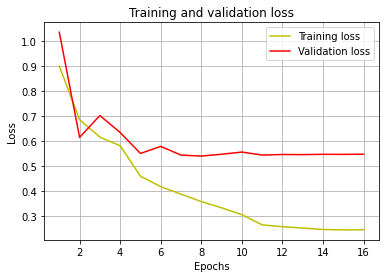

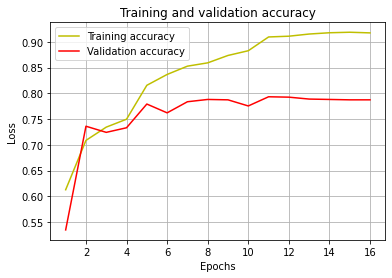

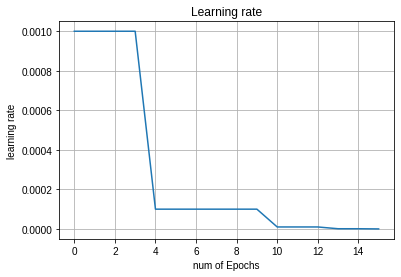

In [48]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#plot the training and validation accuracy and loss at each epoch
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training accuracy')
plt.plot(epochs, val_loss, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

nb_epoch = len(history.history['loss'])
learning_rate=history.history['lr']
xc=range(nb_epoch)
plt.plot(xc,learning_rate)
plt.xlabel('num of Epochs')
plt.ylabel('learning rate')
plt.title('Learning rate')
plt.grid(True)
plt.style.use(['seaborn-ticks'])

In [49]:
from keras.models import load_model

cnn_model = load_model('cnn.h5')

In [50]:
prediction_NN = cnn_model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = le.inverse_transform(prediction_NN)

[[239  46  64   4]
 [ 51 254  33   5]
 [ 35  17 260   9]
 [  4   2   8 314]]


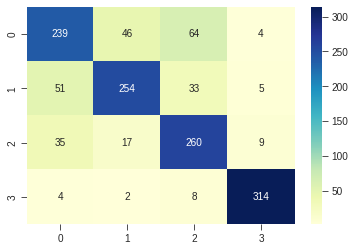

In [51]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, prediction_NN)
print(cm)
sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [52]:
#Now, let us use features from convolutional network for ML
X_for_model = feature_extractor.predict(x_train) 

In [53]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model):
    pred = cross_val_score(model, X_for_model, y_train)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('Accuracy_mymodel', Accuracy)



    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(y_test, predicted)
    mse = metrics.mean_squared_error(y_test, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, predicted))
    r2_square = metrics.r2_score(y_test, predicted)
    Accuracy= metrics.accuracy_score(y_test,predicted)

    return mae, mse, rmse, r2_square, Accuracy

#  KNeighborsClassifier

In [54]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(X_for_model, y_train)
knn_model

KNeighborsClassifier()

In [55]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = knn_model.predict(X_test_feature)

In [56]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.3442379182156134
MSE: 0.5702602230483271
RMSE: 0.7551557607860295
R2 Square 0.5478930175116598
Accuracy_mymodel 0.7620817843866171
__________________________________


In [57]:
results_df = pd.DataFrame(data=[["KNeighborsClassifier", *evaluate(y_test, predicted) ]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel'])
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.344238,0.57026,0.755156,0.547893,0.762082


In [58]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.66      0.68      0.67       353
           1       0.80      0.67      0.73       343
           2       0.67      0.78      0.72       321
           3       0.94      0.93      0.94       328

    accuracy                           0.76      1345
   macro avg       0.77      0.76      0.76      1345
weighted avg       0.77      0.76      0.76      1345



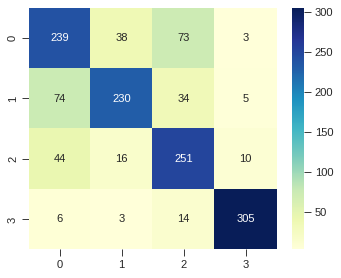

In [59]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(5, 4), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# DecisionTreeClassifier

In [60]:
from sklearn.tree import DecisionTreeClassifier
cart_model = DecisionTreeClassifier()
cart_model = cart_model.fit(X_for_model, y_train)
cart_model

DecisionTreeClassifier()

In [61]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = cart_model.predict(X_test_feature)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.47806691449814126
MSE: 0.7843866171003717
RMSE: 0.8856560376920443
R2 Square 0.3781318558993495
Accuracy_mymodel 0.6639405204460966
__________________________________


In [62]:
results_df_2 = pd.DataFrame(data=[["DecisionTreeClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.344238,0.570260,0.755156,0.547893,0.762082
1,DecisionTreeClassifier,0.478067,0.784387,0.885656,0.378132,0.663941


In [63]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.53      0.55      0.54       353
           1       0.63      0.59      0.61       343
           2       0.60      0.62      0.61       321
           3       0.91      0.91      0.91       328

    accuracy                           0.66      1345
   macro avg       0.67      0.67      0.67      1345
weighted avg       0.66      0.66      0.66      1345



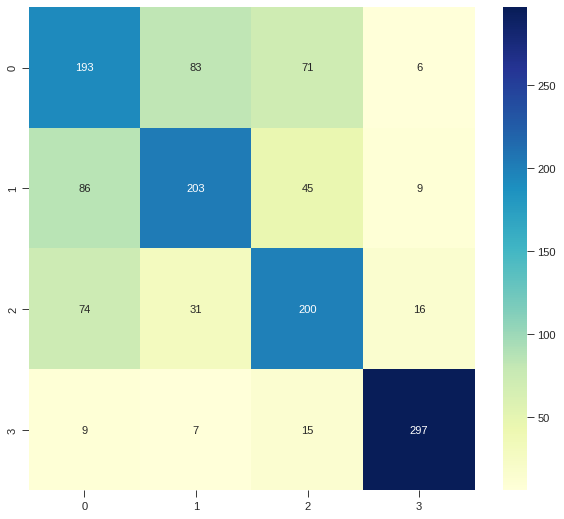

In [64]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# Lojistik regresyon

In [65]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X_for_model, y_train)
lr_model

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [66]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = lr_model.predict(X_test_feature)
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.33011152416356876
MSE: 0.5397769516728624
RMSE: 0.7346951419962313
R2 Square 0.5720604051023012
Accuracy_mymodel 0.7672862453531598
__________________________________


In [67]:
results_df_2 = pd.DataFrame(data=[["LogisticRegression", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.344238,0.570260,0.755156,0.547893,0.762082
1,DecisionTreeClassifier,0.478067,0.784387,0.885656,0.378132,0.663941
2,LogisticRegression,0.330112,0.539777,0.734695,0.572060,0.767286


In [68]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.70      0.67      0.68       353
           1       0.76      0.71      0.73       343
           2       0.69      0.75      0.72       321
           3       0.93      0.94      0.93       328

    accuracy                           0.77      1345
   macro avg       0.77      0.77      0.77      1345
weighted avg       0.77      0.77      0.77      1345



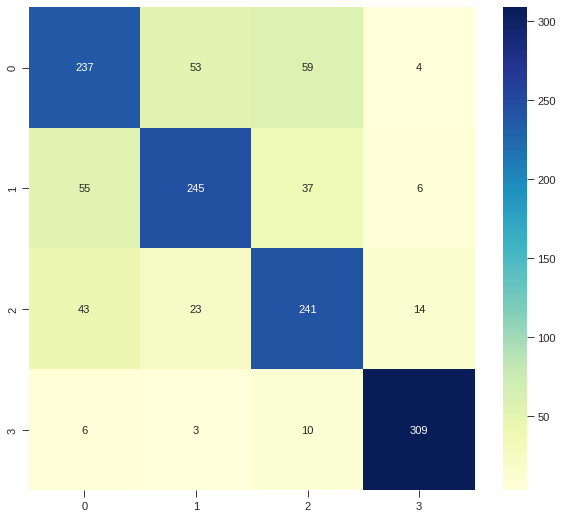

In [69]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# LGBMClassifier

In [70]:
from lightgbm import LGBMClassifier

LGBM_model = LGBMClassifier()
LGBM_model = LGBM_model.fit(X_for_model, y_train)
LGBM_model

LGBMClassifier()

In [71]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = LGBM_model.predict(X_test_feature)

print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.3026022304832714
MSE: 0.5018587360594795
RMSE: 0.7084198868322935
R2 Square 0.6021222774711478
Accuracy_mymodel 0.7903345724907063
__________________________________


In [72]:
results_df_2 = pd.DataFrame(data=[["LGBMClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.344238,0.570260,0.755156,0.547893,0.762082
1,DecisionTreeClassifier,0.478067,0.784387,0.885656,0.378132,0.663941
2,LogisticRegression,0.330112,0.539777,0.734695,0.572060,0.767286
3,LGBMClassifier,0.302602,0.501859,0.708420,0.602122,0.790335


In [73]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71       353
           1       0.79      0.74      0.77       343
           2       0.71      0.78      0.74       321
           3       0.94      0.95      0.95       328

    accuracy                           0.79      1345
   macro avg       0.79      0.79      0.79      1345
weighted avg       0.79      0.79      0.79      1345



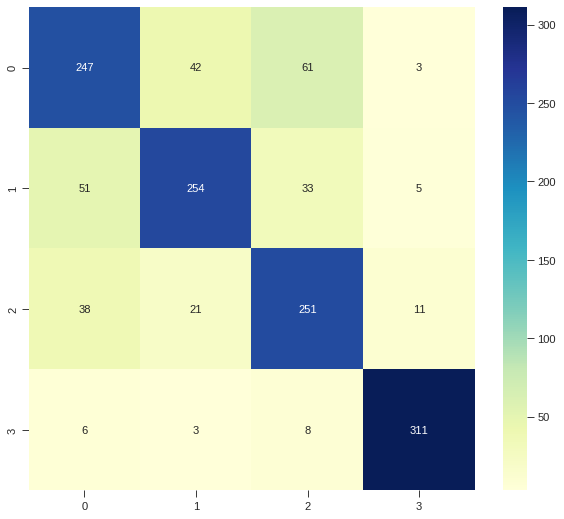

In [74]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# RandomForestClassifier

In [75]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_for_model, y_train)
rf_model

RandomForestClassifier()

In [76]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = rf_model.predict(X_test_feature)

In [77]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.32342007434944237
MSE: 0.5301115241635688
RMSE: 0.728087580009142
R2 Square 0.5797232353139679
Accuracy_mymodel 0.7739776951672862
__________________________________


In [78]:
results_df_2 = pd.DataFrame(data=[["RandomForestClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.344238,0.570260,0.755156,0.547893,0.762082
1,DecisionTreeClassifier,0.478067,0.784387,0.885656,0.378132,0.663941
2,LogisticRegression,0.330112,0.539777,0.734695,0.572060,0.767286
3,LGBMClassifier,0.302602,0.501859,0.708420,0.602122,0.790335
4,RandomForestClassifier,0.323420,0.530112,0.728088,0.579723,0.773978


In [79]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.69      0.67      0.68       353
           1       0.78      0.73      0.75       343
           2       0.71      0.76      0.74       321
           3       0.93      0.95      0.94       328

    accuracy                           0.77      1345
   macro avg       0.77      0.78      0.78      1345
weighted avg       0.77      0.77      0.77      1345



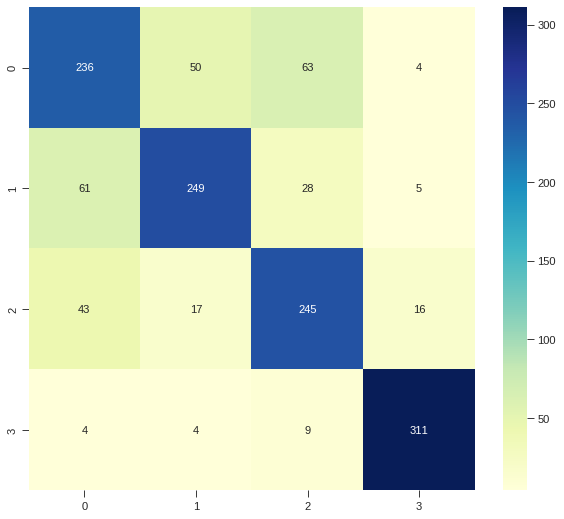

In [80]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# GaussianNB

In [81]:
from sklearn.naive_bayes import GaussianNB


GB_model = GaussianNB()
GB_model = GB_model.fit(X_for_model, y_train)
GB_model

GaussianNB()

In [82]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = GB_model.predict(X_test_feature)

In [83]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.4074349442379182
MSE: 0.6840148698884758
RMSE: 0.8270519148689977
R2 Square 0.4577074004051199
Accuracy_mymodel 0.7226765799256506
__________________________________


In [84]:
results_df_2 = pd.DataFrame(data=[["GaussianNB", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.344238,0.570260,0.755156,0.547893,0.762082
1,DecisionTreeClassifier,0.478067,0.784387,0.885656,0.378132,0.663941
2,LogisticRegression,0.330112,0.539777,0.734695,0.572060,0.767286
3,LGBMClassifier,0.302602,0.501859,0.708420,0.602122,0.790335
4,RandomForestClassifier,0.323420,0.530112,0.728088,0.579723,0.773978
5,GaussianNB,0.407435,0.684015,0.827052,0.457707,0.722677


In [85]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.61      0.58      0.60       353
           1       0.77      0.67      0.71       343
           2       0.62      0.72      0.67       321
           3       0.90      0.94      0.92       328

    accuracy                           0.72      1345
   macro avg       0.73      0.73      0.72      1345
weighted avg       0.72      0.72      0.72      1345



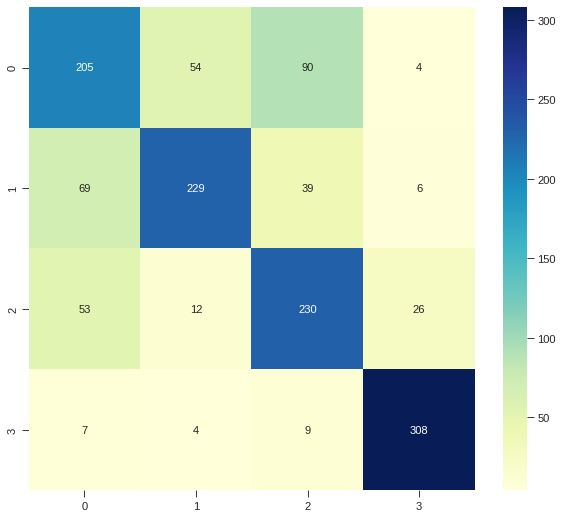

In [86]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# SGDClassifier

In [87]:
from sklearn.linear_model import SGDClassifier

SGD_model = SGDClassifier()
SGD_model = SGD_model.fit(X_for_model, y_train)
SGD_model

SGDClassifier()

In [88]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = SGD_model.predict(X_test_feature)

In [89]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.32342007434944237
MSE: 0.5137546468401487
RMSE: 0.7167668008774881
R2 Square 0.5926911018260195
Accuracy_mymodel 0.762825278810409
__________________________________


In [90]:
results_df_2 = pd.DataFrame(data=[["SGDClassifier", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.344238,0.570260,0.755156,0.547893,0.762082
1,DecisionTreeClassifier,0.478067,0.784387,0.885656,0.378132,0.663941
2,LogisticRegression,0.330112,0.539777,0.734695,0.572060,0.767286
3,LGBMClassifier,0.302602,0.501859,0.708420,0.602122,0.790335
4,RandomForestClassifier,0.323420,0.530112,0.728088,0.579723,0.773978
5,GaussianNB,0.407435,0.684015,0.827052,0.457707,0.722677
6,SGDClassifier,0.323420,0.513755,0.716767,0.592691,0.762825


In [91]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.72      0.64      0.68       353
           1       0.67      0.80      0.73       343
           2       0.74      0.68      0.71       321
           3       0.93      0.94      0.94       328

    accuracy                           0.76      1345
   macro avg       0.77      0.76      0.76      1345
weighted avg       0.77      0.76      0.76      1345



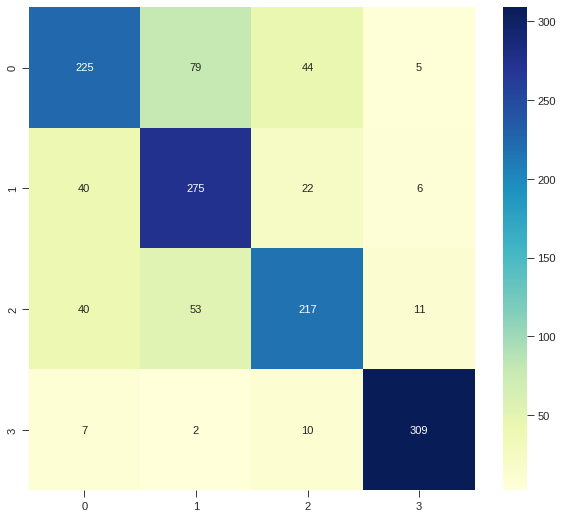

In [92]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

# svc

In [93]:
from sklearn.svm import SVC
svm_model = SVC(kernel = "linear")
svm_model = svm_model.fit(X_for_model, y_train)
svm_model

SVC(kernel='linear')

In [94]:
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
predicted = svm_model.predict(X_test_feature)

In [95]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(y_test, predicted)

Test set evaluation:
_____________________________________
MAE: 0.3397769516728624
MSE: 0.5568773234200743
RMSE: 0.7462421345783649
R2 Square 0.5585030901124292
Accuracy_mymodel 0.7613382899628253
__________________________________


In [96]:
results_df_2 = pd.DataFrame(data=[["SVC", *evaluate(y_test, predicted)]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square','Accuracy_mymodel' ])
results_df = results_df.append(results_df_2, ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.344238,0.570260,0.755156,0.547893,0.762082
1,DecisionTreeClassifier,0.478067,0.784387,0.885656,0.378132,0.663941
2,LogisticRegression,0.330112,0.539777,0.734695,0.572060,0.767286
3,LGBMClassifier,0.302602,0.501859,0.708420,0.602122,0.790335
4,RandomForestClassifier,0.323420,0.530112,0.728088,0.579723,0.773978
5,GaussianNB,0.407435,0.684015,0.827052,0.457707,0.722677
6,SGDClassifier,0.323420,0.513755,0.716767,0.592691,0.762825
7,SVC,0.339777,0.556877,0.746242,0.558503,0.761338


In [97]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66       353
           1       0.74      0.73      0.73       343
           2       0.70      0.74      0.72       321
           3       0.94      0.94      0.94       328

    accuracy                           0.76      1345
   macro avg       0.76      0.76      0.76      1345
weighted avg       0.76      0.76      0.76      1345



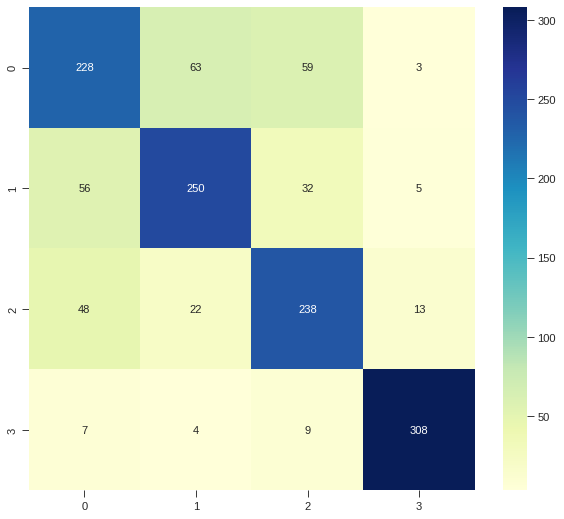

In [98]:
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
figure(figsize=(9, 8), dpi=80)
cm = confusion_matrix(y_test,predicted)

sns.heatmap(cm, annot=True,fmt="d",cmap="YlGnBu")

In [99]:
modeller = [rf_model,GB_model,LGBM_model,SGD_model,lr_model,cart_model,svm_model,knn_model]

In [100]:
from sklearn.metrics import accuracy_score
sonuc = []

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy_mymodel"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test_feature)
    dogruluk = accuracy_score(y_test, y_pred)    
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy_mymodel"])
    sonuclar = sonuclar.append(sonuc)

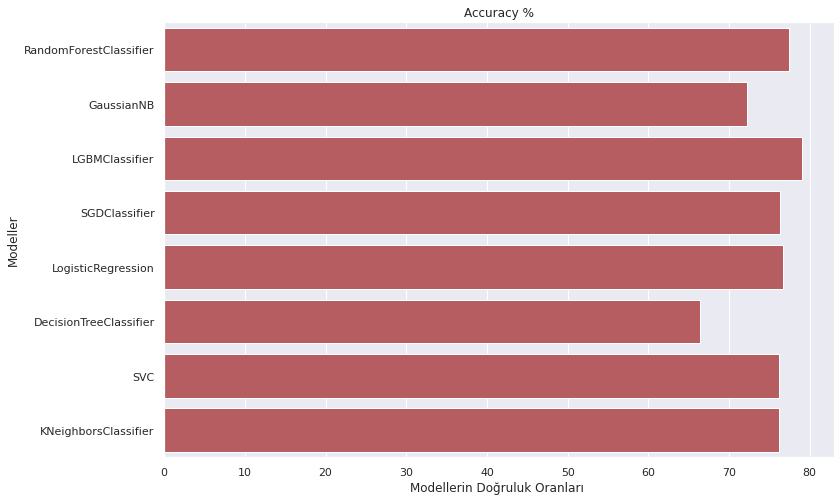

In [101]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x= 'Accuracy_mymodel', y = 'Modeller', data=sonuclar, color="r")
plt.xlabel('Modellerin Doğruluk Oranları ')
plt.title('Accuracy %');




In [102]:
results_df

,Model,MAE,MSE,RMSE,R2 Square,Accuracy_mymodel
0,KNeighborsClassifier,0.344238,0.570260,0.755156,0.547893,0.762082
1,DecisionTreeClassifier,0.478067,0.784387,0.885656,0.378132,0.663941
2,LogisticRegression,0.330112,0.539777,0.734695,0.572060,0.767286
3,LGBMClassifier,0.302602,0.501859,0.708420,0.602122,0.790335
4,RandomForestClassifier,0.323420,0.530112,0.728088,0.579723,0.773978
5,GaussianNB,0.407435,0.684015,0.827052,0.457707,0.722677
6,SGDClassifier,0.323420,0.513755,0.716767,0.592691,0.762825
7,SVC,0.339777,0.556877,0.746242,0.558503,0.761338


In [103]:
best_acc=sonuclar.sort_values(by=['Accuracy_mymodel'], ascending=False)
en_iyi_model_my_model=best_acc[:1]
en_iyi_model_my_model


,Modeller,Accuracy_mymodel
0,LGBMClassifier,79.033457


In [ ]:
from google.colab import files

results_df.to_csv('output_mymodel.csv', encoding = 'utf-8-sig') 
files.download('output_mymodel.csv')